In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

#Avoid Running Unnecessary Code
runChessBoardCorners=False
runCameraCalibration=False

In [2]:
### Find ChessBoard Corners ###
nx= 9 # Corners on the x-axis of chessboard
ny= 6 # Corners on the y-axis of chessboard

if(runChessBoardCorners):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob("./camera_cal/*.jpg")

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = './output_images/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(50)

    #cv2.destroyAllWindows()

    dist_pickle = {}
    dist_pickle["objpoints"] = objpoints
    dist_pickle["imgpoints"] = imgpoints
    pickle.dump( dist_pickle, open( "./wide_dist_pickle.p", "wb" ) )

In [3]:
### Camera Calibration ###
if(runCameraCalibration):
    # Test undistortion on an image
    img = cv2.imread('./camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    #dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "./wide_dist_pickle.p", "wb" ) )
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
### Create undistorted images ###

dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

images=[]

# Read in all images to calibrate camera
for file in glob.glob("./camera_cal/*.jpg"):
    img = cv2.imread(file)
    images.append(img)

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist=cv2.undistort(img, mtx, dist, None, mtx)

    return undist

for idx,image in enumerate(images):
    undistorted = cal_undistort(image, objpoints, imgpoints)
    cv2.imwrite('output_images/undist_'+str(idx)+'.jpg',undistorted)

    if(False):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
### Create and write warped images
for idx,file in enumerate(glob.glob('./output_images/undist_*.jpg')):
    img=cv2.imread(file)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if (ret == True):
        cv2.drawChessboardCorners(img,(nx,ny),corners,ret)

        offset=100
        img_size=(img.shape[1],img.shape[0])

        src=np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
        dst=np.float32([[offset,offset],
        [img_size[0]-offset,offset],
        [img_size[0]-offset,img_size[1]-offset],
        [offset,img_size[1]-offset]])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
        
        cv2.imwrite('output_images/unwarped_'+str(idx)+'.jpg',warped)
    
    doPrint=False
    if(doPrint):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped)
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)        

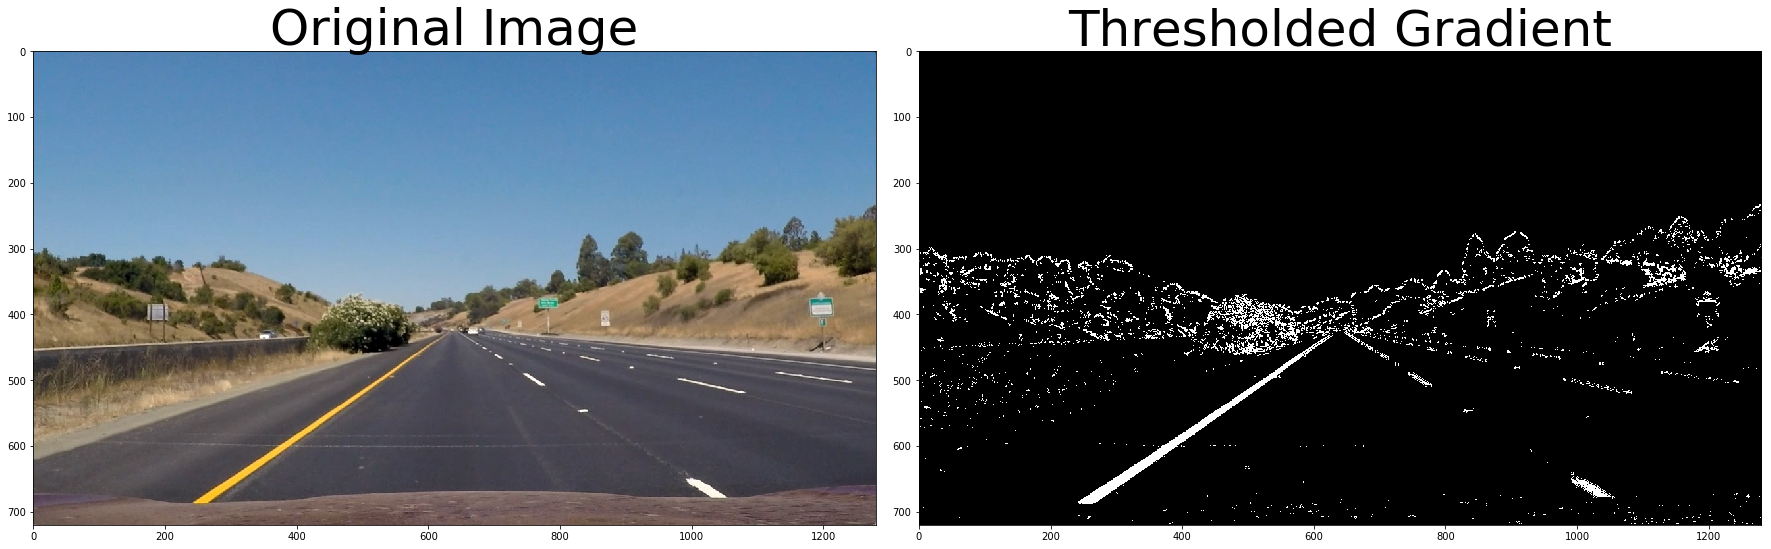

In [6]:
#Apply Sobelx, sobely, magnitude, direction and color

# Read in an image and grayscale it
image = mpimg.imread('./test_images/straight_lines1.jpg')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh_x(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sx=cv2.Sobel(gray,cv2.CV_64F,1,0)
    # 3) Take the absolute value of the derivative or gradient
    abs=np.absolute(sx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled=(255*abs)/np.max(abs)
    scaled=np.uint8(scaled)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary=np.zeros_like(scaled)
    sxbinary[(scaled>thresh_min) & (scaled<thresh_max)] = 1
    # 6) Return this mask as your binary_output image
     
    return sxbinary

def abs_sobel_thresh_y(img, orient='y', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sy=cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs=np.absolute(sy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled=(255*abs)/np.max(abs)
    scaled=np.uint8(scaled)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sybinary=np.zeros_like(scaled)
    sybinary[(scaled>thresh_min) & (scaled<thresh_max)] = 1
    # 6) Return this mask as your binary_output image
     
    return sybinary
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy=np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled=np.uint8((255*abs_sobelxy)/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary=np.zeros_like(scaled)
    binary[(scaled>mag_thresh[0]) & (scaled<mag_thresh[1])]=1
    # 6) Return this mask as your binary_output image
   
    return binary
    
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x=np.absolute(sobelx)
    abs_y=np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction=np.arctan2(abs_y,abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(direction)
    binary_output[(direction>thresh[0]) & (direction<thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

def color_binary(img, color_thresh=(0,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel>=color_thresh[0])&(s_channel<=color_thresh[1])]=1
    
    return s_binary

# Run the Sobelx
gradx = abs_sobel_thresh_x(image, orient='x', thresh_min=20, thresh_max=255)
# Run the Sobely
grady = abs_sobel_thresh_y(image, orient='y', thresh_min=20, thresh_max=150)
# Run the Magnitude
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Run the Direction
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(.8, 1.2))
#Run the Color
s_binary=color_binary(image,color_thresh=(150,255))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1

##Show lines to define source points
show_lines=False
if(show_lines):
    img_shp=image.shape
    mask_y_height=int(img_shp[0]*0.6)
    
    cv2.line(image,(int(img_shp[1]*0.15),img_shp[0]),(int(img_shp[1]*0.45),mask_y_height),(0,0,255),5)
    cv2.line(image,(int(img_shp[1]*0.45),mask_y_height),(int(img_shp[1]*0.55),mask_y_height),(0,0,255),5)
    cv2.line(image,(int(img_shp[1]*0.55),mask_y_height),(int(img_shp[1]*0.95),img_shp[0]),(0,0,255),5)       
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.show()

In [7]:
## Warp Road Images
for idx,file in enumerate(glob.glob('./test_images/*.jpg')):
    
    img = mpimg.imread(file)
    img_shp=img.shape
    mask_y_height = int(img_shp[0]*0.7) #Upper bound of y
    offset=img.shape[0]*0.25 #Offset
    img_size=(img.shape[1],img.shape[0])
    
    # Run the Sobelx
    gradx = abs_sobel_thresh_x(img, orient='x', thresh_min=20, thresh_max=255)
    # Run the Sobely
    grady = abs_sobel_thresh_y(img, orient='y', thresh_min=20, thresh_max=150)
    # Run the Magnitude
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    # Run the Direction
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(.8, 1.2))
    #Run the Color
    s_binary=color_binary(img,color_thresh=(150,255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1

    upper_right=(int(img_shp[1]*0.60),mask_y_height)
    lower_right=(int(img_shp[1]*0.85),img_shp[0]*0.95)
    lower_left=(int(img_shp[1]*0.20),img_shp[0]*0.95)
    upper_left=(int(img_shp[1]*0.41),mask_y_height)
  
    #Source Points taken from approximate lines on image
    src=np.float32([upper_left,
                    upper_right,
                    lower_right,
                    lower_left])
    
    dst=np.float32([[offset,0],
                    [img_size[0]-offset,0],
                    [img_size[0]-offset,img_size[1]],
                    [offset,img_size[1]]])
    '''
    plt.imshow(img)
    plt.plot(upper_left[0],upper_left[1],'.')
    plt.plot(upper_right[0],upper_right[1],'.')
    plt.plot(lower_right[0],lower_right[1],'.')
    plt.plot(lower_left[0],lower_left[1],'.')
    '''
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)*255

    saveImages=True
    if(saveImages):
        cv2.imwrite('output_images/warped_combined'+str(idx)+'.jpg',warped)    
    
    plotResult=False
    if(plotResult):
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Warped Lane Image'+str(i), fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        plt.show()


In [ ]:
def warped_combined(img):
    
    img_shp=img.shape
    mask_y_height = int(img_shp[0]*0.7) #Upper bound of y
    offset=img.shape[0]*0.25 #Offset
    img_size=(img.shape[1],img.shape[0])
    
    # Run the Sobelx
    gradx = abs_sobel_thresh_x(img, orient='x', thresh_min=20, thresh_max=255)
    # Run the Sobely
    grady = abs_sobel_thresh_y(img, orient='y', thresh_min=20, thresh_max=150)
    # Run the Magnitude
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    # Run the Direction
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(.8, 1.2))
    #Run the Color
    s_binary=color_binary(img,color_thresh=(150,255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1

    upper_right=(int(img_shp[1]*0.60),mask_y_height)
    lower_right=(int(img_shp[1]*0.85),img_shp[0]*0.95)
    lower_left=(int(img_shp[1]*0.20),img_shp[0]*0.95)
    upper_left=(int(img_shp[1]*0.41),mask_y_height)
  
    #Source Points taken from approximate lines on image
    src=np.float32([upper_left,
                    upper_right,
                    lower_right,
                    lower_left])
    
    dst=np.float32([[offset,0],
                    [img_size[0]-offset,0],
                    [img_size[0]-offset,img_size[1]],
                    [offset,img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)*255

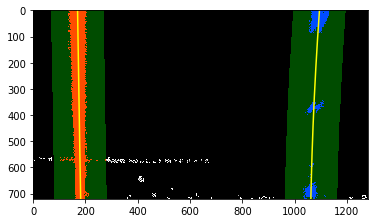

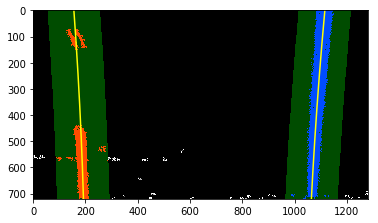

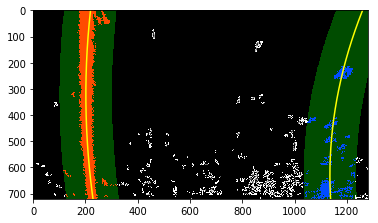

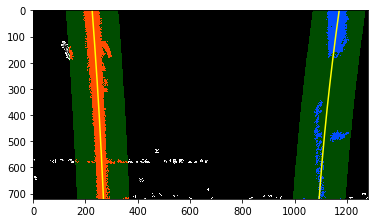

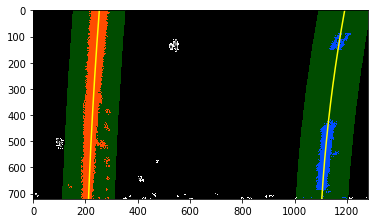

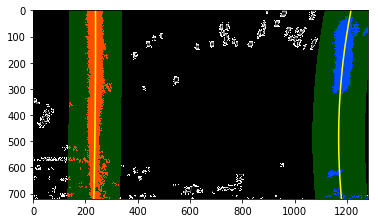

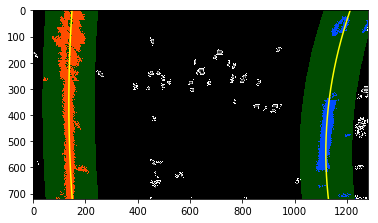

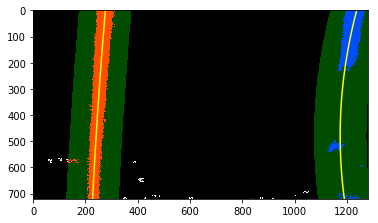

In [8]:
##Histogram, slice into windows, polyfit, fillpoly
for idx,file in enumerate(glob.glob('./output_images/warped_combined*.jpg')):
    binary_warped=cv2.imread(file)
    binary_warped=cv2.cvtColor(binary_warped,cv2.COLOR_RGB2GRAY)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    #plt.plot(histogram) 
    #plt.show()

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #Closer to top
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        #Closer to bottom
        win_y_high = binary_warped.shape[0] - window*window_height
        #left mid according to histogram - margin
        win_xleft_low = leftx_current - margin
        #left mid according to histogram + margin
        win_xleft_high = leftx_current + margin
        #right mid according to histogram - margin
        win_xright_low = rightx_current - margin
        #right mid according to histogram + margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #left low,right high points
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    printOut=False
    if(printOut):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

In [9]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("left curve rad:{0} right curve rad:{1}".format(left_curverad, right_curverad))
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("left curve radius:{0} meter right curve radius:{1} meter".format(left_curverad, right_curverad))
# Example values: 632.1 m    626.2 m

left curve rad:1647.9344208680645 right curve rad:1547.7546760534874
left curve radius:541.2399441940793 meter right curve radius:508.0275534007087 meter


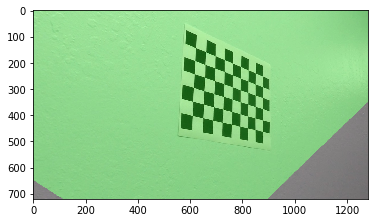

In [20]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [11]:
line_left=Line()
line_right=Line()



False


In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
output='./output_images/video1.mp4'

clip=VideoFileClip('project_video.mp4').subclip(0,2)
%time clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video ./output_images/video1.mp4
[MoviePy] Writing video ./output_images/video1.mp4


 98%|█████████████████████████████████████████▏| 50/51 [00:01<00:00, 36.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/video1.mp4 

Wall time: 2.68 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))